# COMPLETED AUTOMATE THE PROCESS 

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
import joblib

import seaborn as sns

In [17]:
import pandas as pd

# Load the datasets from separate files
file_path = r"completed-iot-datasets.xlsx"

# Load and clean the training dataset
mgh_data = pd.read_excel(file_path)

# Display the first few rows of the dataframe
mgh_data.head()



,time,global out,global in,temp in,temp out,rh in,rh out,co2 in,co2 out,toplights,ventilation,heater,Unnamed: 12,Unnamed: 13
0,0,0.032943,0.0,19.806459,22.685000,62.243682,52.775000,409.000000,1530.5,1,0.0,0,dataset3,May
1,300,0.032943,0.0,19.806459,22.685000,62.243682,52.775000,409.000000,1530.5,1,0.0,0,NaN,NaN
2,600,0.032943,0.0,19.889053,22.745000,62.040377,52.510000,409.000000,1506.5,1,0.0,0,NaN,NaN
3,900,0.032943,0.0,20.017409,22.823333,61.694059,52.213333,408.333333,1455.0,1,0.0,0,NaN,NaN
4,1200,0.032943,0.0,20.145762,22.865000,61.322003,52.015000,408.000000,1413.0,1,0.0,0,NaN,NaN


In [18]:
def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

def train_and_evaluate_model(target_variable, flag_train, _epochs=100, _batch_size=10):
    features = ['time', 'global out', 'temp out', 'rh out', 'co2 out', 'ventilation', 'toplights', 'heater']
    
    X = mgh_data[features]
    y = mgh_data[target_variable]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

    # Initialize and fit the scaler on the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if flag_train:
        # model = Sequential()
        # model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
        # model.add(Dense(32, activation='relu'))
        # model.add(Dense(1))
        
        # model = Sequential()
        # model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # More neurons
        # model.add(Dense(64, activation='relu'))  # Additional hidden layer
        # model.add(Dense(32, activation='relu'))  # Additional hidden layer
        # model.add(Dense(1))
        
        model = Sequential()
        model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dropout(0.2))  # Dropout after input layer
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))  # Dropout after first hidden layer
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))  # Dropout after second hidden layer
        model.add(Dense(1))
        
        # Adam optimizer
        # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
        '''
        Args
        learning_rate	A float, a keras.optimizers.schedules.LearningRateSchedule instance, 
                        or a callable that takes no arguments and returns the actual value to use. 
                        The learning rate. Defaults to 0.001.
        
        use_ema	Boolean, defaults to False. If True, exponential moving average (EMA) is applied. 
                        EMA consists of computing an exponential moving average of the weights of the model 
                        (as the weight values change after each training batch), and periodically overwriting 
                        the weights with their moving average.
                        
        ema_momentum	Float, defaults to 0.99. Only used if use_ema=True. 
                        This is the momentum to use when computing the EMA of the model's weights: new_average = ema_momentum * old_average + (1 - ema_momentum) * current_variable_value.
        
        The learning rate was lifted by one order of magnitude, and the momentum was increased to 0.9. 
        These increases in the learning rate were also recommended in the original Dropout paper (https://jmlr.org/papers/v15/srivastava14a.html)
        
        '''
        adam = Adam(learning_rate=0.001, use_ema=True, ema_momentum=0.9)
        
        # changed adam compare to rmsprop
        model.compile(optimizer=adam, 
                      loss='mean_squared_error', 
                      metrics=['mae', r2_score_metric])

        history = model.fit(X_train_scaled, y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)
        
        # Save the model in the recommended Keras format
        model.save(f'trained-nn-dropout-models/{target_variable}_model.keras')

        # Save the scaler
        joblib.dump(scaler, f'trained-nn-dropout-models/{target_variable}_scaler.pkl')

        y_hat_test = model.predict(X_test_scaled)
    else:
        # Load the model using the native Keras format
        loaded_model = load_model(f'trained-nn-dropout-models/{target_variable}_model.keras', custom_objects={'r2_score_metric': r2_score_metric})
        
        # Print model summary
        print("\nModel Summary:")
        loaded_model.summary()

        # Count total parameters
        total_params = loaded_model.count_params()
        print(f"Total number of parameters: {total_params}")
        
        # Load the scaler
        scaler = joblib.load(f'trained-nn-dropout-models/{target_variable}_scaler.pkl')
        
        # Scale the test data
        X_test_scaled = scaler.transform(X_test)
        
        y_hat_test = loaded_model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)
    
    if flag_train:
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['r2_score_metric'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_r2_score_metric'], color='b', label='validation')

        plt.title('R2 during training')
        plt.ylabel('R2')
        plt.xlabel('epoch')
        plt.legend(loc='lower right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()


Epoch 1/100


c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3191/3191 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 1.5701 - mae: 0.6749 - r2_score_metric: -5.7752 - val_loss: 0.5828 - val_mae: 0.3577 - val_r2_score_metric: 0.6957
Epoch 2/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.7636 - mae: 0.4361 - r2_score_metric: 0.6196 - val_loss: 0.5155 - val_mae: 0.3104 - val_r2_score_metric: 0.7644
Epoch 3/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6631 - mae: 0.3925 - r2_score_metric: 0.6713 - val_loss: 0.5086 - val_mae: 0.2997 - val_r2_score_metric: 0.7636
Epoch 4/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.6603 - mae: 0.3867 - r2_score_metric: 0.7096 - val_loss: 0.5075 - val_mae: 0.3033 - val_r2_score_metric: 0.7637
Epoch 5/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.5926 - mae: 0.3694 - r2_score_metric: 0.7594 - val_loss: 0.4795 - val_mae: 0.2918 - val_r2_score_metric: 0.7883
Epoch 6/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.5292 - mae: 0.3580 - r2_score_metric: 0.7670 - val_loss: 0.47

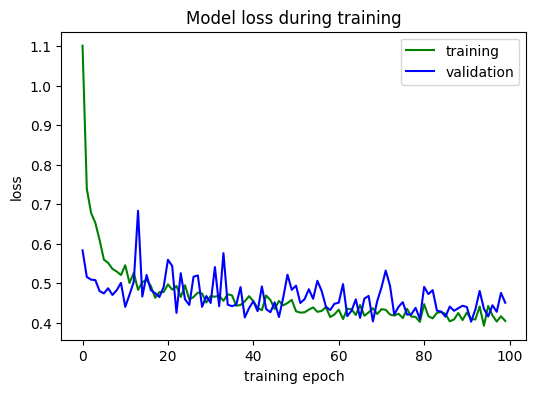

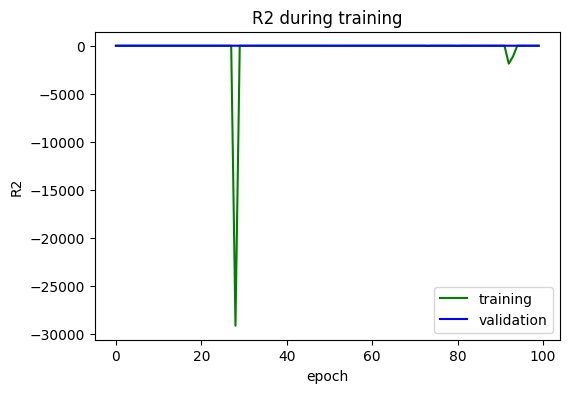

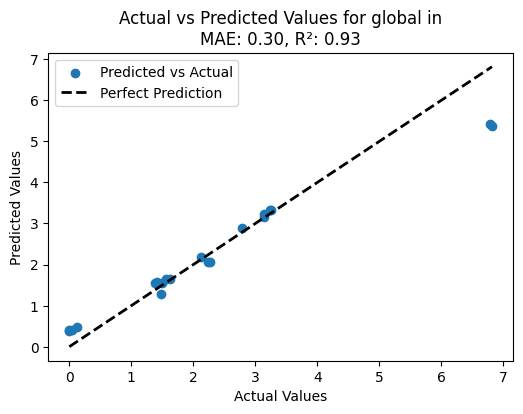

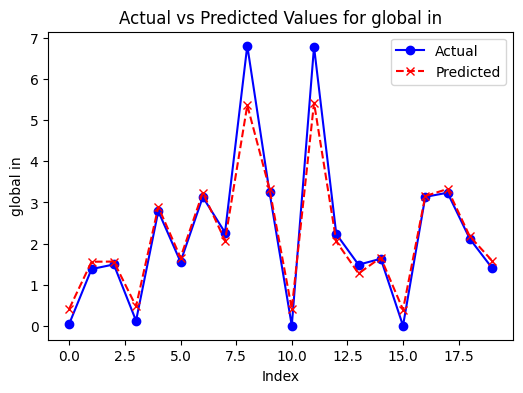

Epoch 1/100


c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3191/3191 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 63.2308 - mae: 5.4768 - r2_score_metric: -73.8013 - val_loss: 0.6212 - val_mae: 0.6049 - val_r2_score_metric: 0.2388
Epoch 2/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 13.5270 - mae: 2.9261 - r2_score_metric: -13.2189 - val_loss: 0.5068 - val_mae: 0.5837 - val_r2_score_metric: 0.4252
Epoch 3/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 10.9935 - mae: 2.6380 - r2_score_metric: -12.6775 - val_loss: 0.8525 - val_mae: 0.7540 - val_r2_score_metric: 0.1216
Epoch 4/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 10.0313 - mae: 2.5028 - r2_score_metric: -11.5184 - val_loss: 1.2476 - val_mae: 1.0044 - val_r2_score_metric: -0.5164
Epoch 5/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 8.3195 - mae: 2.2798 - r2_score_metric: -9.1337 - val_loss: 0.3305 - val_mae: 0.4237 - val_r2_score_metric: 0.6978
Epoch 6/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 7.1345 - mae: 2.1246 - r2_score_metric: -8.1079 - 

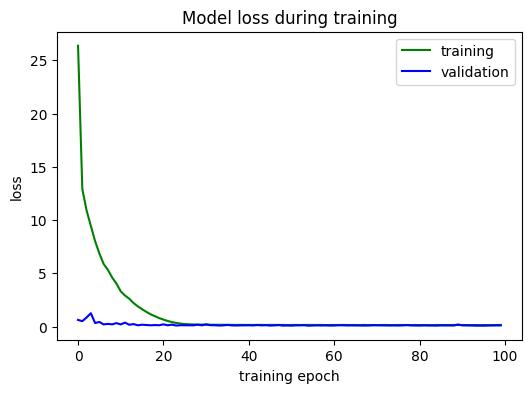

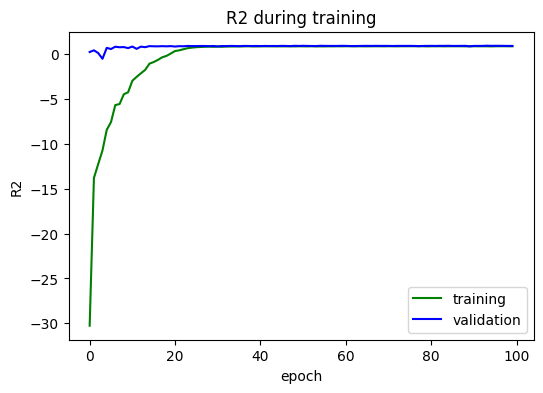

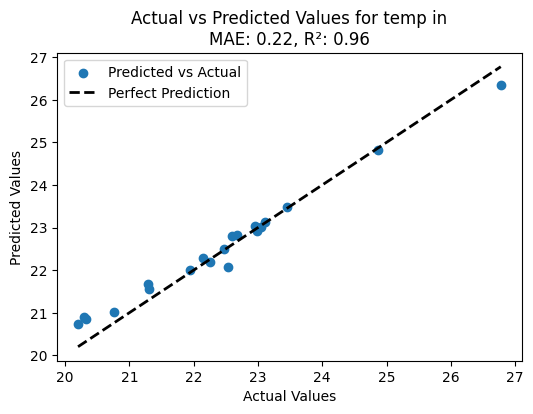

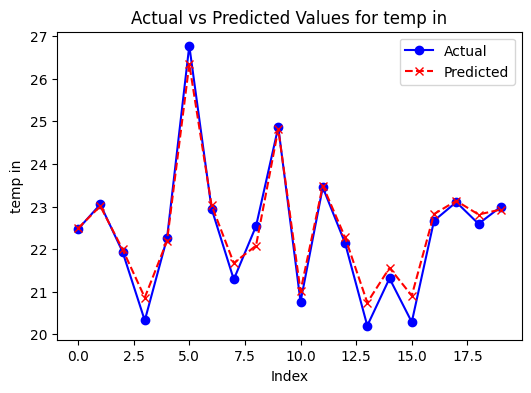

Epoch 1/100


c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3191/3191 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 421.8002 - mae: 13.7575 - r2_score_metric: -32.1335 - val_loss: 6.6204 - val_mae: 1.9011 - val_r2_score_metric: -0.0239
Epoch 2/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 77.5291 - mae: 6.9938 - r2_score_metric: -5.2770 - val_loss: 10.7682 - val_mae: 2.6038 - val_r2_score_metric: -0.7992
Epoch 3/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 70.0343 - mae: 6.6362 - r2_score_metric: -4.9693 - val_loss: 6.2269 - val_mae: 1.9764 - val_r2_score_metric: 0.3113
Epoch 4/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 64.6662 - mae: 6.3394 - r2_score_metric: -4.6917 - val_loss: 6.4977 - val_mae: 2.2311 - val_r2_score_metric: -0.0357
Epoch 5/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 60.6405 - mae: 6.1980 - r2_score_metric: -4.1548 - val_loss: 7.1614 - val_mae: 2.1950 - val_r2_score_metric: 0.1600
Epoch 6/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 55.4053 - mae: 5.9053 - r2_score_metric: -3.934

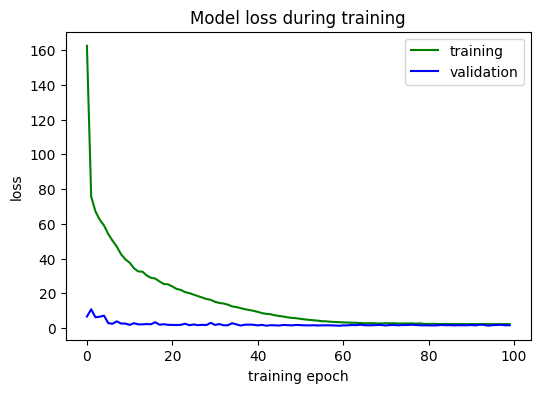

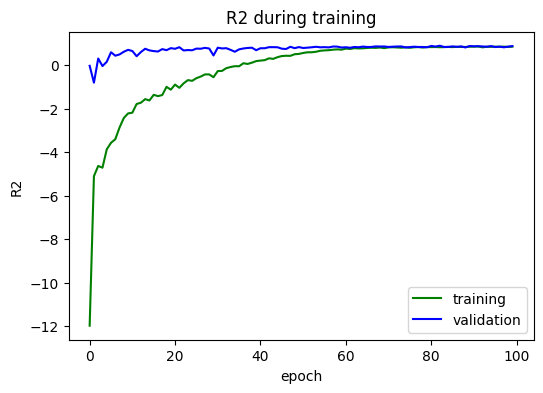

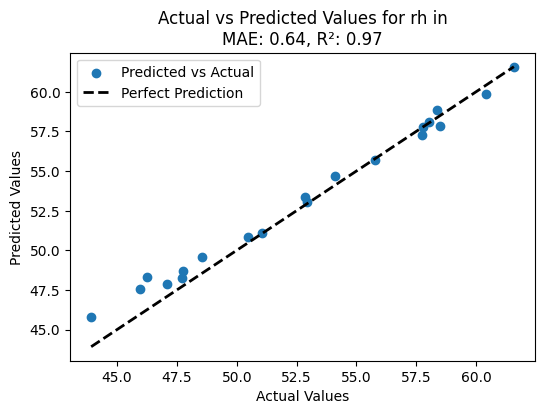

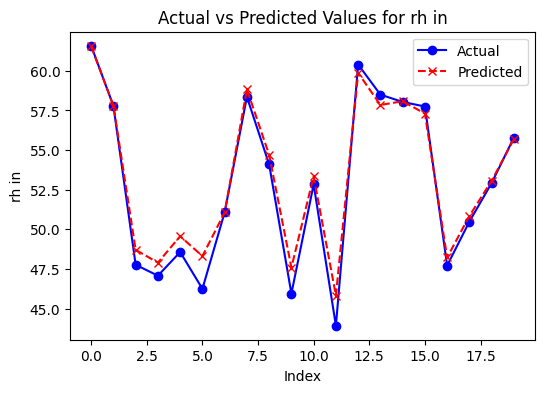

Epoch 1/100


c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3191/3191 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 29403.0449 - mae: 116.5527 - r2_score_metric: -447341199360.0000 - val_loss: 722.5193 - val_mae: 24.3319 - val_r2_score_metric: -9226210304.0000
Epoch 2/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 4843.8867 - mae: 55.7225 - r2_score_metric: -68500279296.0000 - val_loss: 117.9564 - val_mae: 7.4010 - val_r2_score_metric: -1289884416.0000
Epoch 3/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 4830.4487 - mae: 54.7870 - r2_score_metric: -76676038656.0000 - val_loss: 131.8123 - val_mae: 7.5722 - val_r2_score_metric: -1132856064.0000
Epoch 4/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 4757.6323 - mae: 54.4291 - r2_score_metric: -67282464768.0000 - val_loss: 136.7359 - val_mae: 8.5710 - val_r2_score_metric: -1476490112.0000
Epoch 5/100
3191/3191 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 4786.7769 - mae: 54.1767 - r2_score_metric: -69576179712.0000 - val_loss: 194.9246 - val_mae: 11.6567 - val_r2_score_metric: -229

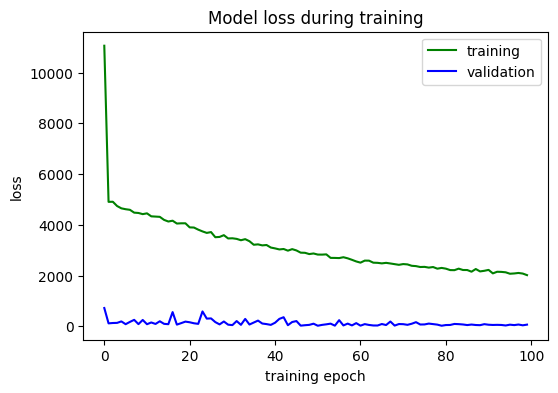

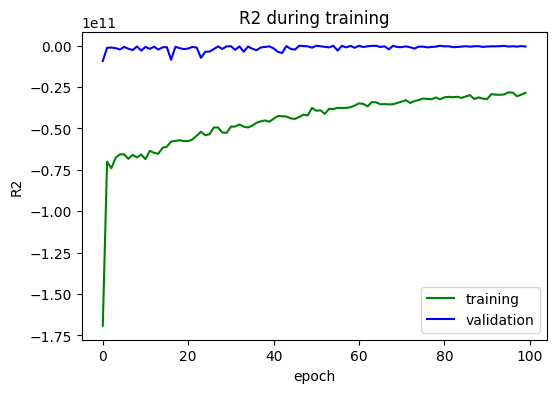

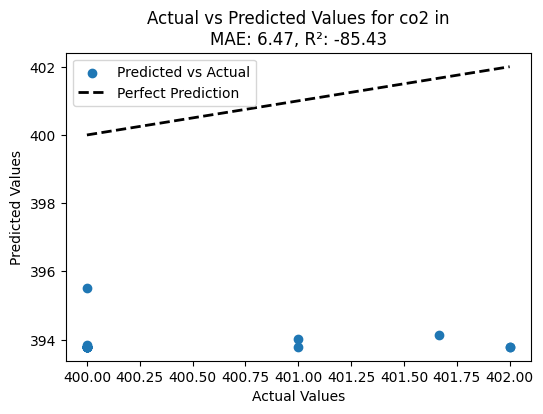

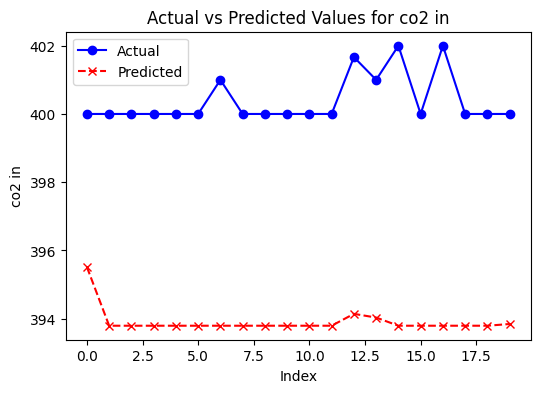

In [19]:
# List of target variables
target_variables = ['global in', 'temp in', 'rh in', 'co2 in']

# Iterate through each target variable and call the function
for target in target_variables:
    train_and_evaluate_model(target, flag_train = True, _epochs = 100, _batch_size= 5)

In [ ]:
train_and_evaluate_model('temp in', flag_train = False)

# Test with test datasets with trained model


In [20]:
# Load the datasets from separate files
file_path_test = r"test-iot-datasets.xlsx"

# Load and clean the test dataset
mgh_data_test = pd.read_excel(file_path_test)

# Display the first few rows of the cleaned training and test dataframes
print("\nTest Data Sample:")
print(mgh_data_test.head())

num_rows_test = len(mgh_data_test)
print(f'Number of rows test: {num_rows_test}')


Test Data Sample:
   time  global out  global in  temp in  temp out  rh in  rh out  co2 in  \
0  1200    0.000000   0.000000    21.80      22.8  51.65    49.5     400   
1  1500    0.029625   1.354850    22.15      22.7  51.05    49.7     400   
2  1800    0.032943   1.331150    23.35      22.8  48.05    49.2     400   
3  2100    0.032943   1.323250    24.15      23.0  46.05    48.6     400   
4  2400    0.010981   0.439635    24.60      23.0  44.55    48.2     400   

   co2 out  ventilation  toplights  heater  
0      613            0          1       1  
1      619            0          1       1  
2      623            0          1       1  
3      618            0          0       1  
4      602            0          0       1  
Number of rows test: 60


In [21]:
def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

def test_model(target_variable):
    features = ['time', 'global out', 'temp out', 'rh out', 'co2 out', 'ventilation', 'toplights', 'heater']
    
    X_test = mgh_data_test[features]
    y_test = mgh_data_test[target_variable]

    # Load the model using the native Keras format
    loaded_model = load_model(f'trained-nn-dropout-models/{target_variable}_model.keras', custom_objects={'r2_score_metric': r2_score_metric})
    
    # Load the scaler
    scaler = joblib.load(f'trained-nn-dropout-models/{target_variable}_scaler.pkl')
    
    # Scale the test data
    X_test_scaled = scaler.transform(X_test)
    
    y_hat_test = loaded_model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)
    
    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()

In [ ]:
# List of target variables
target_variables = ['global in', 'temp in', 'rh in', 'co2 in']

test_model(target_variable = target_variables[1])

In [ ]:
# List of target variables
target_variables = ['global in', 'temp in', 'rh in', 'co2 in']

test_model(target_variable = target_variables[2])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

Target Variable: global in
MAE: 1.00
R²: 0.74


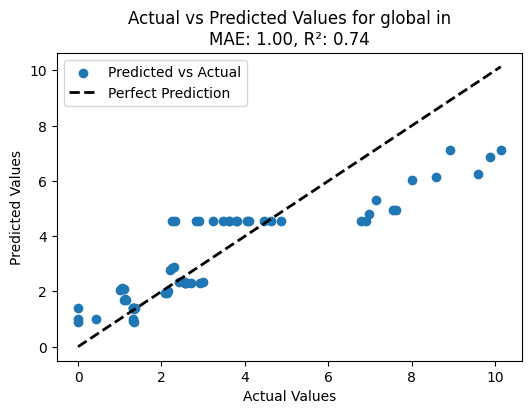

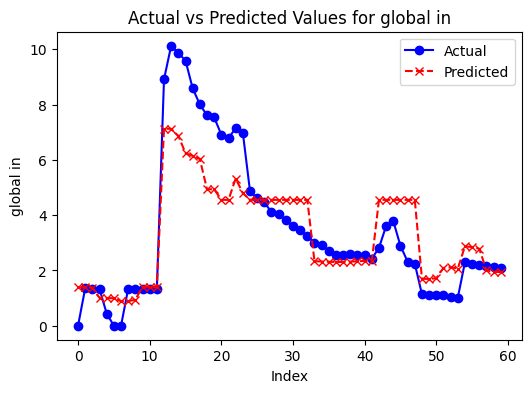

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Target Variable: temp in
MAE: 0.94
R²: 0.81


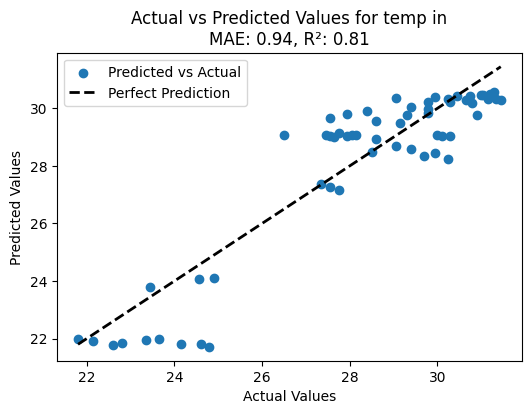

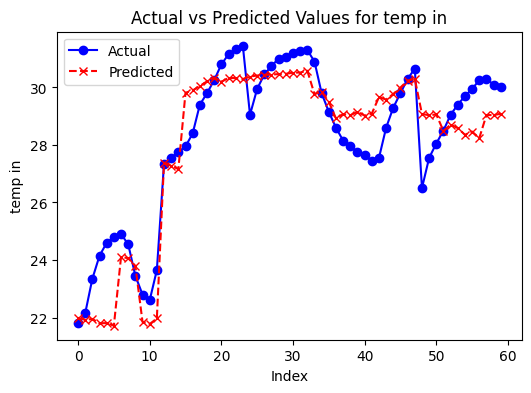

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

Target Variable: rh in
MAE: 2.68
R²: 0.14


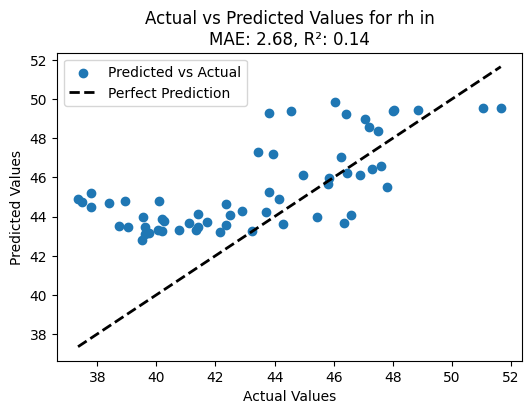

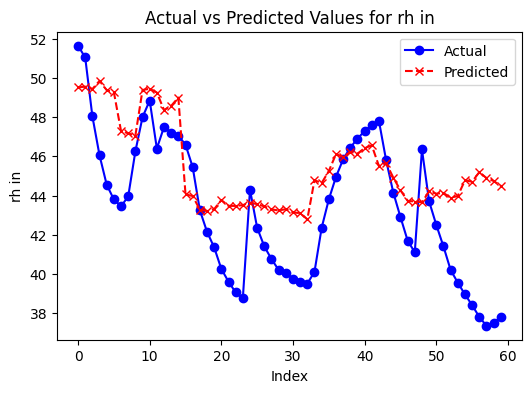

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Target Variable: co2 in
MAE: 5.59
R²: 0.00


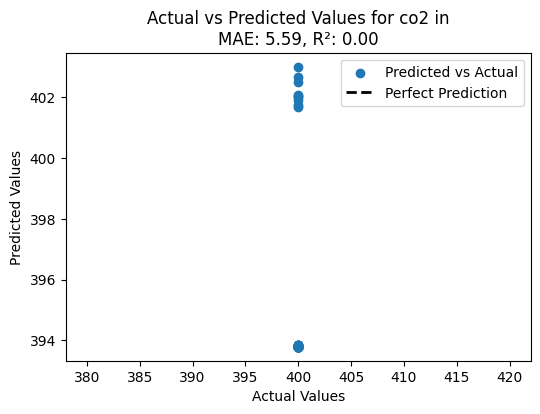

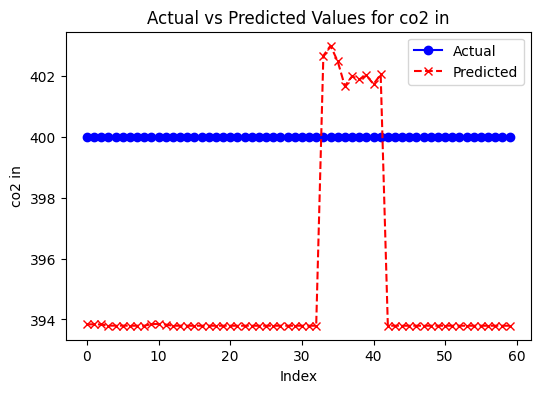

In [22]:
# List of target variables
target_variables = ['global in', 'temp in', 'rh in', 'co2 in']

# Iterate through each target variable and call the function
for target in target_variables:
    test_model(target)

# AUTOMATE THE PROCESS 

Separate between the training and test datasets

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

import seaborn as sns

In [ ]:
import pandas as pd

# Load the datasets from separate files
file_path_training = r"train-iot-datasets.xlsx"
file_path_test = r"test-iot-datasets-compiled-2-converted.xlsx"

# Load and clean the training dataset
mgh_data_training = pd.read_excel(file_path_training)
#mgh_data_training = mgh_data_training.dropna()  # Drop rows with missing values

# Load and clean the test dataset
mgh_data_test = pd.read_excel(file_path_test)
#mgh_data_test = mgh_data_test.dropna()  # Drop rows with missing values

# Display the first few rows of the cleaned training and test dataframes
print("Training Data Sample:")
print(mgh_data_training.head())

print("\nTest Data Sample:")
print(mgh_data_test.head())

# Length of dataset
num_rows_training = len(mgh_data_training)
print(f'\nNumber of rows training: {num_rows_training}')

num_rows_test = len(mgh_data_test)
print(f'Number of rows test: {num_rows_test}')

# Show all rows and columns of the test dataframe
# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns

# print("\nFull Test Data:")
# print(mgh_data_test)

# # Reset options to default
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')


In [ ]:
def train_and_evaluate_model(target_variable, _epochs=100, _batch_size=10):
    # Select features and target variable for training and test data
    features = ['time', 'global out', 'temp out', 'temp out', 'rh out', 'co2 out', 'ventilation', 'toplights', 'heater']
    
    # Training data
    X_train = mgh_data_training[features]
    y_train = mgh_data_training[target_variable]
    
    # Test data
    X_test = mgh_data_test[features]
    y_test = mgh_data_test[target_variable]

    # Normalize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build the ANN model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer for regression

    # Compile the model
    # model.compile(optimizer='adam', loss='mean_squared_error')
    model.compile(loss='mse', metrics=['mae', 'R2Score'], optimizer='rmsprop')

    # Train the model
    history = model.fit(X_train_scaled, y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)

    # Make predictions on the test set
    y_hat_test = model.predict(X_test_scaled)

    # Calculate MAE and R² score
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)
    
    # Plot loss (MSE) for both training and validation split
    plt.figure(figsize=(6, 4))
    sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
    plt.title('Model loss during training')
    plt.ylabel('loss')
    plt.xlabel('training epoch')
    plt.legend(loc='upper right')
    
    # Plot R2 for both training and validation split
    plt.figure(figsize=(6, 4))
    sns.lineplot(x=history.epoch, y=history.history['R2Score'], color='g', label='training')
    sns.lineplot(x=history.epoch, y=history.history['val_R2Score'], color='b', label='validation')

    plt.title('R2 during training')
    plt.ylabel('R2')
    plt.xlabel('epoch')
    plt.legend(loc='lower right')

    # Print MAE and R²
    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    # Plotting the test vs predicted values
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()
    
    # Plot the test vs predicted values in order
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()

In [ ]:
# List of target variables
target_variables = ['global in', 'temp in', 'rh in', 'co2 in']

# Iterate through each target variable and call the function
for target in target_variables:
    train_and_evaluate_model(target, 200, 4)